# American Housing Survey Project

Explore year 2013 of national and metro datasets from the [Housing Affordability Data System (HADS)](https://www.huduser.gov/portal/datasets/hads/hads.html) data source.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.cluster import KMeans
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import os.path

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Read data

In [2]:
# Read Natinal Data 
national_url = 'https://www.huduser.gov/portal/datasets/hads/hads2013n_ASCII.zip'
national_file = 'thads2013n.txt'

if os.path.exists(national_file):
    df_national = pd.read_csv(national_file)
else: 
    z_national = urlopen(national_url)
    zip_national = ZipFile(BytesIO(z_national.read())).extract(national_file)
    df_national = pd.read_csv(zip_national)

In [3]:
df_national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64535 entries, 0 to 64534
Data columns (total 99 columns):
CONTROL                64535 non-null object
AGE1                   64535 non-null int64
METRO3                 64535 non-null object
REGION                 64535 non-null object
LMED                   64535 non-null int64
FMR                    64535 non-null int64
L30                    64535 non-null int64
L50                    64535 non-null int64
L80                    64535 non-null int64
IPOV                   64535 non-null int64
BEDRMS                 64535 non-null int64
BUILT                  64535 non-null int64
STATUS                 64535 non-null object
TYPE                   64535 non-null int64
VALUE                  64535 non-null int64
VACANCY                64535 non-null int64
TENURE                 64535 non-null object
NUNITS                 64535 non-null int64
ROOMS                  64535 non-null int64
WEIGHT                 64535 non-null float64
PER 

In [4]:
df_national.head()

,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,...,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,'100003130103',82,'3','1',73738,956,15738,26213,40322,11067,...,'1 LTE 50% FMR','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','.','2 30% to 50%','-5','-5'
1,'100006110249',50,'5','3',55846,1100,17165,28604,45744,24218,...,'3 GT FMR','4 60 - 80% AMI','4 60 - 80% AMI','6 100 - 120% AMI','4 60 - 80% AMI','7 120% AMI +','.','1 Less than 30%','-5','-5'
2,'100006370140',53,'5','3',55846,1100,13750,22897,36614,15470,...,'2 50.1 - 100% FMR','4 60 - 80% AMI','5 80 - 100% AMI','6 100 - 120% AMI','4 60 - 80% AMI','4 60 - 80% AMI','.','3 50% or More','-5','-5'
3,'100006520140',67,'5','3',55846,949,13750,22897,36614,13964,...,'2 50.1 - 100% FMR','6 100 - 120% AMI','7 120% AMI +','7 120% AMI +','5 80 - 100% AMI','4 60 - 80% AMI','.','1 Less than 30%','-5','-5'
4,'100007130148',26,'1','3',60991,737,14801,24628,39421,15492,...,'3 GT FMR','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','7 120% AMI +','0 Not Assisted','1 Less than 30%','-5','-5'


## Initial Exploratory questions
### Pairwise visualizations

Useful columns 
- `ZINC2`: Household Income
- `ZSMHC`: Monthly Housing Costs
- `ROOMS`: Number of rooms in unit
- `PER`: Number of persons in household
- `GLMED`: Growth-adjusted median income
- `AGE1`: Age of head of household

In [5]:
# Make dictionary of columns and names
init_num_col_names = {'ZINC2': ' Household Income', 'ZSMHC': 'Monthly Housing Costs', 
                      'ROOMS': 'Number of rooms in unit', 
                      'PER': 'Number of persons in household', 'GLMED': 'Growth-adjusted median income', 
                      'AGE1': 'Age of head of household'}

In [6]:
# Make function for scatter plot 
def plot_2D(x_col, y_col, df, col_names_dict):
    plt.figure(figsize=(6,6))
    plt.scatter(df[x_col], df[y_col], s=10, alpha=0.3)
    plt.xlabel(col_names_dict[x_col])
    plt.ylabel(col_names_dict[y_col]);

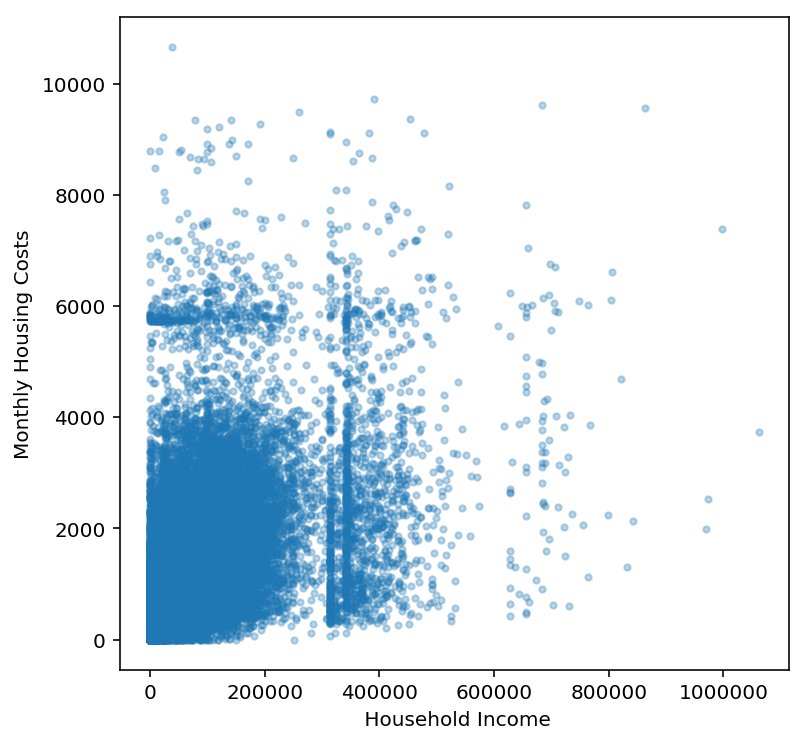

In [7]:
plot_2D(x_col='ZINC2', y_col='ZSMHC', df=df_national, col_names_dict=init_num_col_names)

### 3D Visualizations

In [8]:
def plot_3D(x_col, y_col, z_col, df, col_names_dict):
    plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(df[x_col], df[y_col], df[z_col], c=df[z_col], cmap='Greens')
    ax.set_xlabel(col_names_dict[x_col])
    ax.set_ylabel(col_names_dict[y_col])
    ax.set_zlabel(col_names_dict[z_col]);

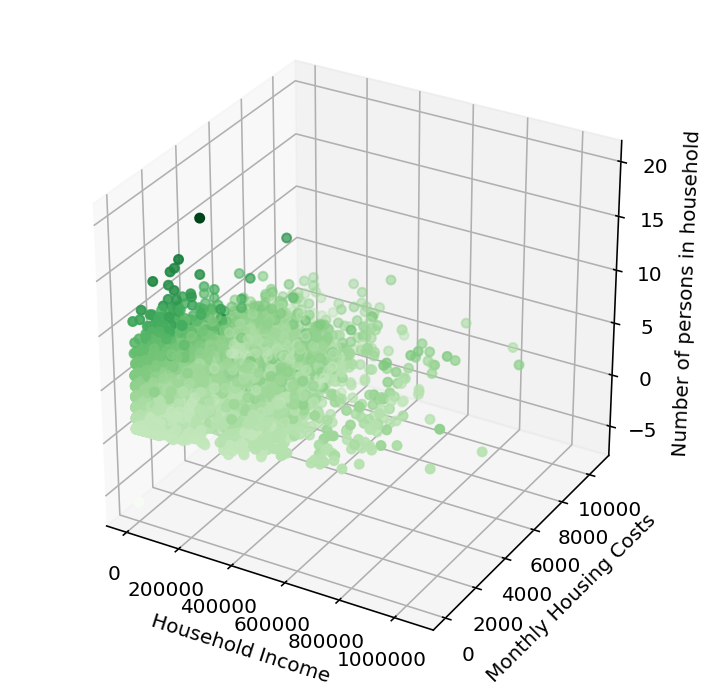

In [9]:
plot_3D(x_col='ZINC2', y_col='ZSMHC', z_col='PER',df=df_national, col_names_dict=init_num_col_names)

### K Means Clustering

In [7]:
# Get Numerical Columns 
num_cols = ['ZINC2', 'ZSMHC', 'ROOMS', 'PER', 'GLMED']
df_national_num = df_national[num_cols].copy()

# Impuse missing values
imputer = Imputer(strategy='median')
national_num_imputed = imputer.fit_transform(df_national_num)

# Scale numeric features
scaler = StandardScaler()
national_num_standardized = scaler.fit_transform(national_num_imputed)

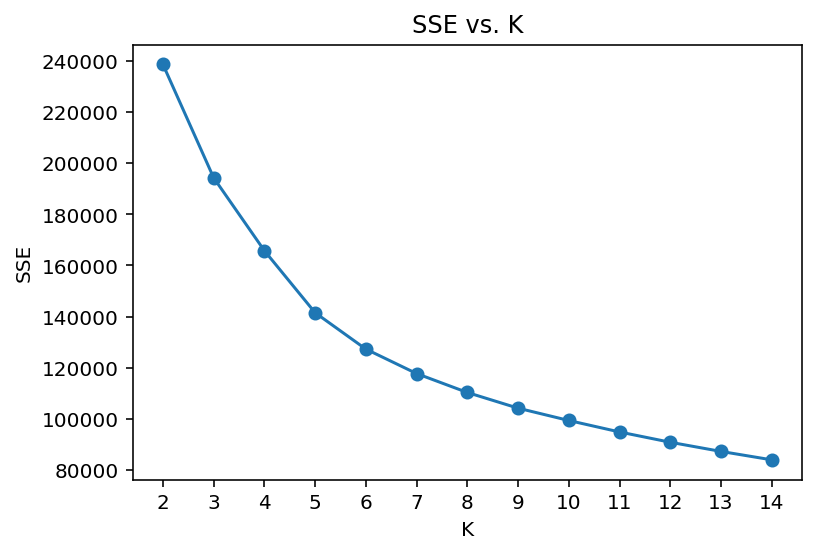

In [8]:
sse = []

k_range = np.arange(2, 15)

for k in k_range:
    kmeans = KMeans(k).fit(national_num_standardized)
    sse.append(np.abs(kmeans.score(national_num_standardized)))
    
plt.plot(k_range, sse, linestyle='-', marker='o', )
plt.xlabel('K')
plt.ylabel('SSE')
plt.xticks(k_range)
plt.title('SSE vs. K')
plt.show()

From elbow method, it looks like the optimal number of clusters is `5`

In [9]:
kmeans = KMeans(5).fit(national_num_standardized)

kmeans_labels = kmeans.predict(national_num_standardized)

In [10]:
df_national_num_imputed = pd.DataFrame(national_num_imputed, columns = df_national_num.columns)
df_national_num_imputed['segment'] = kmeans_labels

In [24]:
def plot_boxplot(col):
    df_national_num_imputed.boxplot(column=[col], by='segment', figsize=(8,6))
    plt.xlabel('K Means segment')
    plt.ylabel(col)
    plt.show()

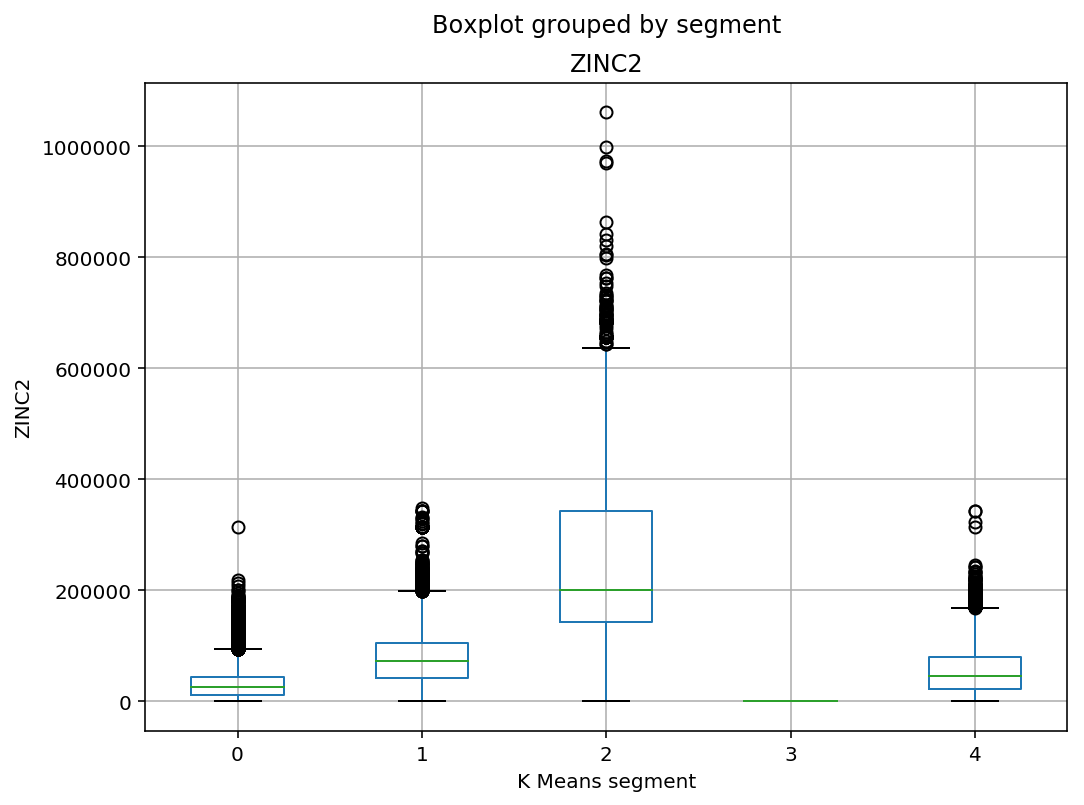

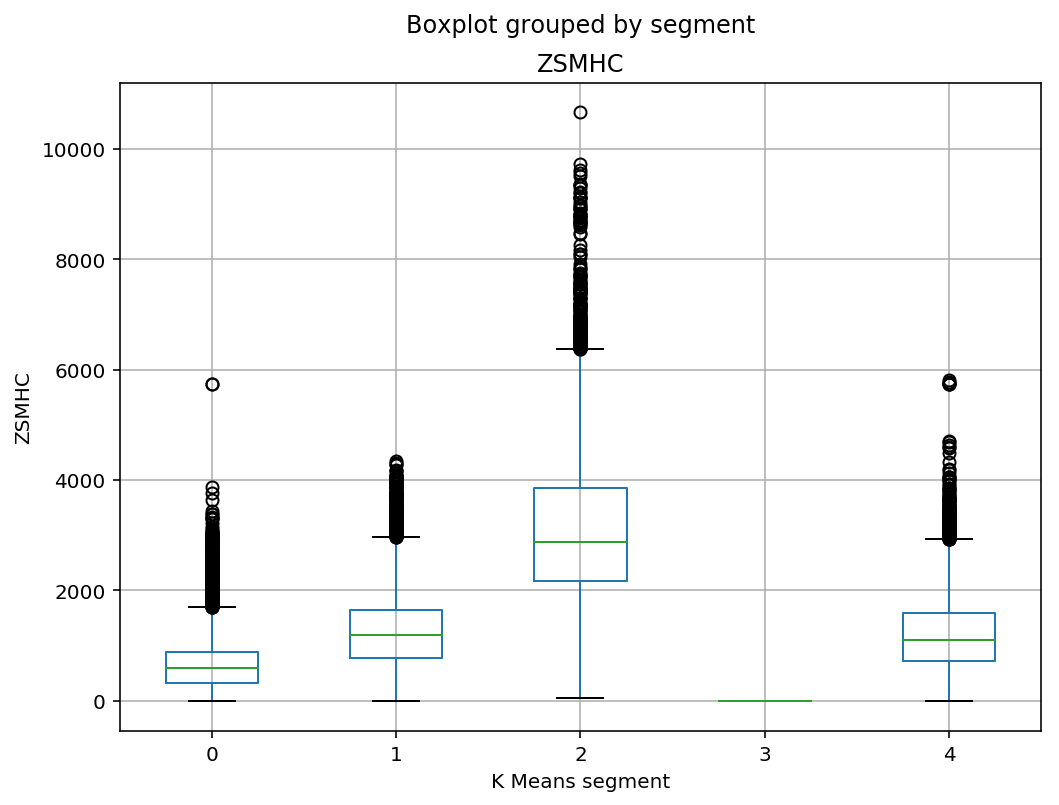

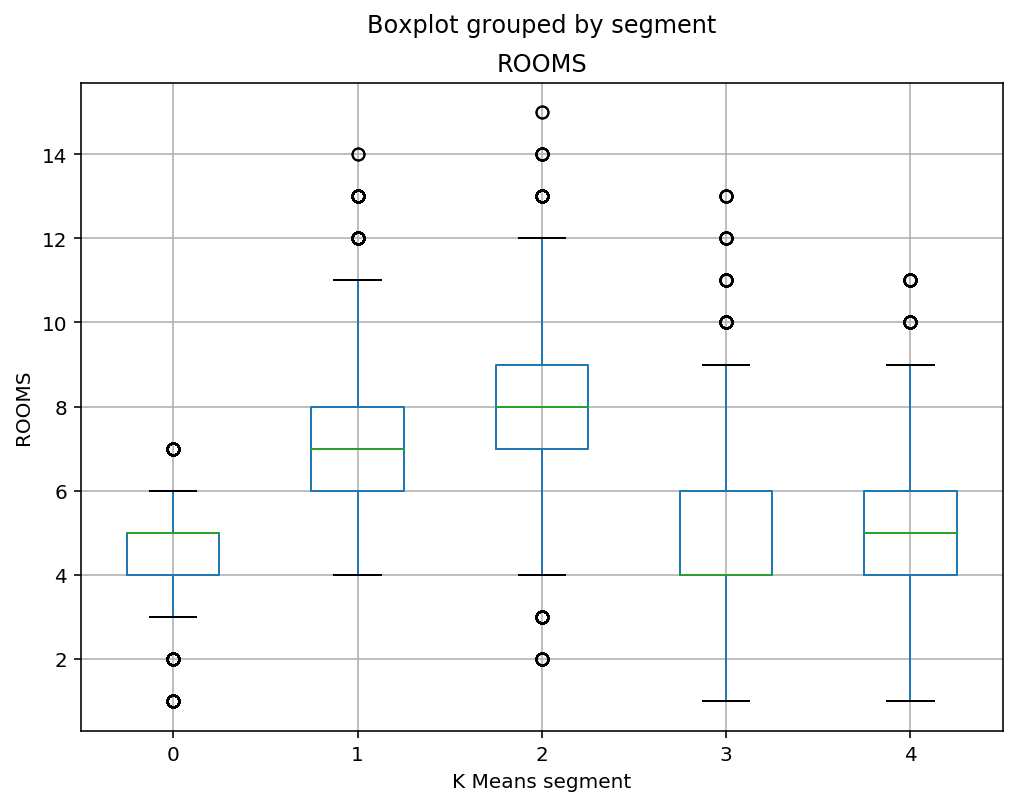

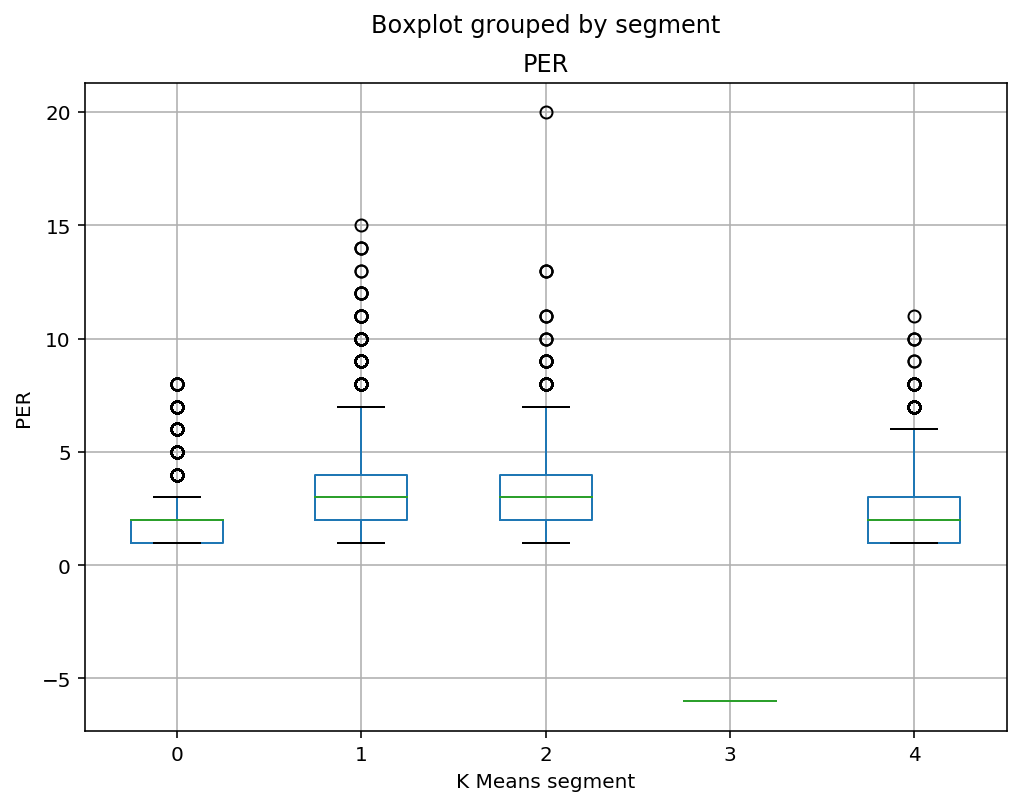

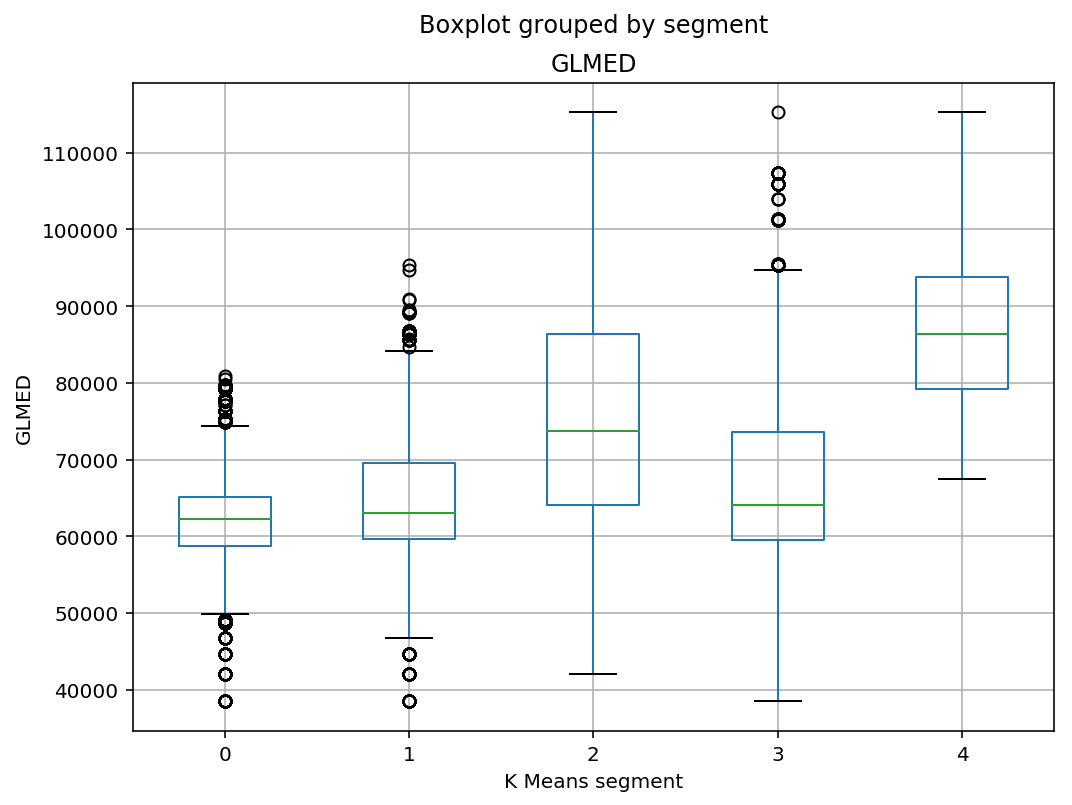

In [25]:
for col in num_cols:
    plot_boxplot(col)